In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [3]:
# Load settings
from backend import sett, postgres
from backend.utils.frame import Frame
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

      -- postgres_ SSH tunnel established.
NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.049 s)


In [8]:
import json
import datetime
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("~/matplotlib.mplstyle")
except: pass

In [9]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [10]:
def timings(seconds : int):
    # Total time on the pipeline.
    print(str(datetime.timedelta(seconds = seconds)))
    print(f"{seconds / 3600 :.2f} hours")

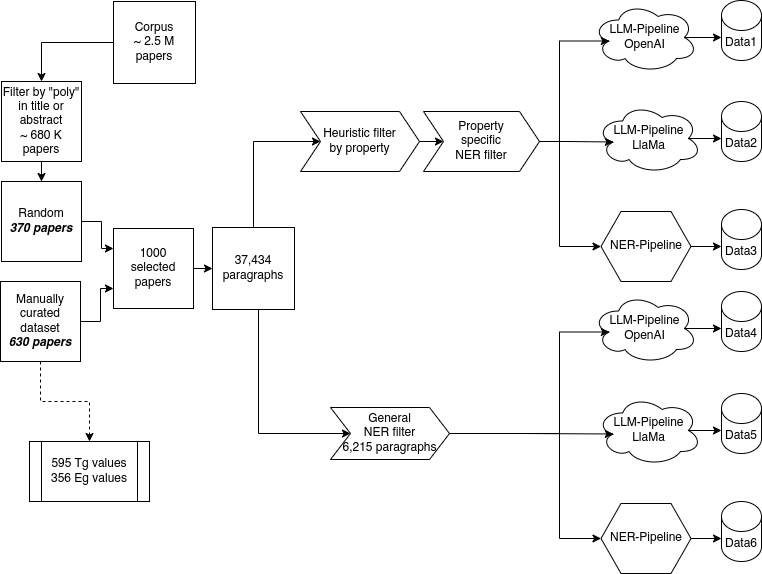

In [7]:
from IPython.display import Image
Image(filename="notebooks/Figure01.png")

In [7]:
# List of extraction methods.
execute("""select * from extraction_methods order by dataset""")

,name,dataset,model,api,para_subset,extraction_info,id,date_added
0,bandgap-ner-bert-sel1k,data3,materials-bert,None,bandgap-ner-sel1k,{'user': 'sonakshi'},9,2023-09-28 15:47:13.043706-04:00
1,tg-ner-bert-sel1k,data3,materials-bert,None,tg-ner-sel1k,{'user': 'sonakshi'},8,2023-09-28 15:38:51.455998-04:00
2,g-ner-gpt35-rand-sel1k,data4,gpt-3.5-turbo,openai,select-1k_ner-filter,"{'user': 'akhlak', 'shot_selector': 'random', ...",3,2023-09-26 08:53:00-04:00
3,g-ner-llama1-sel1k,data5,wizard-vicuna-30B,polyai,select-1k_ner-filter,"{'user': 'akhlak', 'shot_selector': 'random', ...",4,2023-09-26 08:54:00-04:00
4,g-ner-bert-sel1k,data6,materials-bert,None,select-1k_ner-filter,{'user': 'akhlak'},5,2023-09-26 08:56:00-04:00
5,g-ner-pipeline,data7,materials-bert,None,ner_filter,{'user': 'akhlak'},1,2023-09-25 19:37:00-04:00
6,test3,test,gpt-3.5,openai,test,"{'user': 'akhlak', 'n_shots': '1'}",7,2023-09-28 15:29:28.854659-04:00
7,test,test-data,test-model,polyai,select-1k_ner-filter,"{'comment': 'Method for testing purposes.', 'u...",2,2023-09-25 23:20:00-04:00


In [9]:
# Number of selected papers.
execute("""
    SELECT count(*) FROM filtered_papers fp 
    WHERE fp.filter_name = 'select-1k';
""")

,count
0,1000


In [10]:
# Number of the selected papers from the curated dataset.
execute("""
SELECT count(*) FROM filtered_papers fp 
WHERE fp.filter_name = 'select-1k'
AND EXISTS (
	SELECT 1 FROM curated_data cd 
	WHERE cd.doi = fp.doi
);""")

,count
0,630


In [11]:
# Number of paragraphs from the select 1k.
execute("""
    SELECT count(*) FROM paper_texts pt 
    JOIN filtered_papers fp ON fp.doi = pt.doi 
    WHERE fp.filter_name = 'select-1k';
""")

,count
0,37434


## Data6 - General NER - NER Pipeline.

In [12]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where dataset = 'data6';
""")[0]
method

Row(name='g-ner-bert-sel1k', dataset='data6', model='materials-bert', api=None, para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak'}, id=5, date_added=datetime.datetime(2023, 9, 26, 8, 56, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [13]:
# Number of paragraphs that passed the General NER filter.
execute("""
        SELECT count(*) FROM filtered_paragraphs fp 
        WHERE fp.filter_name = :method_para;
        
        """, method_para = method.para_subset)

,count
0,6215


In [14]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,9106


In [15]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,16368


In [16]:
# F1-score for Tg.
with open("runs/select-1k/bert/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-bert-sel1k', 'material': {'true_positives': 701, 'false_positives': 77, 'false_negatives': 146, 'precision': 0.9010282776349614, 'recall': 0.8276269185360094, 'F1': 0.8627692307692308}, 'value': {'true_positives': 544, 'false_positives': 234, 'false_negatives': 46, 'precision': 0.699228791773779, 'recall': 0.9220338983050848, 'F1': 0.7953216374269008}, 'property': {'true_positives': 432, 'false_positives': 346, 'false_negatives': 161, 'precision': 0.5552699228791774, 'recall': 0.7284991568296796, 'F1': 0.6301969365426696}}


In [17]:
# F1-score for Bandgap.
with open("runs/select-1k/bert/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-bert-sel1k', 'material': {'true_positives': 332, 'false_positives': 21, 'false_negatives': 118, 'precision': 0.9405099150141643, 'recall': 0.7377777777777778, 'F1': 0.8268991282689913}, 'value': {'true_positives': 317, 'false_positives': 36, 'false_negatives': 23, 'precision': 0.8980169971671388, 'recall': 0.9323529411764706, 'F1': 0.9148629148629148}, 'property': {'true_positives': 233, 'false_positives': 120, 'false_negatives': 121, 'precision': 0.660056657223796, 'recall': 0.6581920903954802, 'F1': 0.659123055162659}}


In [18]:
# Time for filtering.
!grep "All done." runs/select-1k/filter/*.log

[23-09-26 EDT 08:57:06 AM] NOTE  -- All done. (took 2516.329 s)


In [19]:
# Time for extraction.
!grep "All done." runs/select-1k/bert/ner-filtered*.log

runs/select-1k/bert/ner-filtered.01.log:[23-09-27 EDT 02:59:47 PM] NOTE  -- All done. (took 42.097 s)
runs/select-1k/bert/ner-filtered.log:[23-09-27 EDT 03:43:35 PM] NOTE  -- All done. (took 2254.671 s)


In [15]:
# Time for scoring.
!grep "All done." runs/select-1k/bert/metrics.log

[23-09-30 EDT 08:21:22 AM] NOTE  -- All done. (took 21.939 s)


In [16]:
timings(2516 + 42 + 2254 + 21)

1:20:33
1.34 hours


## Data5 - General NER - LlaMa 1 Pipeline.

In [22]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where dataset = 'data5';
""")[0]
method

Row(name='g-ner-llama1-sel1k', dataset='data5', model='wizard-vicuna-30B', api='polyai', para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak', 'shot_selector': 'random', 'n_shots': 1, 'api_retry_delay': 30, 'delay_multiplier': 0.5, 'max_api_retries': 1, 'api_request_delay': 0, 'temperature': 0.001, 'prompt_id': 0, 'prompt': "Extract all numbers in JSONL format with 'material', 'property', 'value', 'condition' columns."}, id=4, date_added=datetime.datetime(2023, 9, 26, 8, 54, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [23]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,1109


In [24]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,1396


In [25]:
# Number of tokens.
df = execute("""
             SELECT para_id, request_tokens, response_tokens, request_tokens + response_tokens AS total_tokens
             FROM  api_requests ar WHERE ar.method_id = :mid;
             
             """, mid=method.id)

df['api_cost'] = 0

print(f"Total tokens: {df['total_tokens'].sum():,}")
print(f"Total cost: $ {df['api_cost'].sum():.2f}")
print(f"Number of requests: {df.shape[0]:,}")
df

Total tokens: 683,311.0
Total cost: $ 0.00
Number of requests: 1,415


,para_id,request_tokens,response_tokens,total_tokens,api_cost
0,5334951,1197.0,181.0,1378.0,0
1,5334958,1545.0,279.0,1824.0,0
2,5334959,1038.0,71.0,1109.0,0
3,5334960,989.0,74.0,1063.0,0
4,5334961,1419.0,78.0,1497.0,0
...,...,...,...,...,...
1410,7738357,1039.0,88.0,1127.0,0
1411,7738359,724.0,65.0,789.0,0
1412,7744720,769.0,83.0,852.0,0
1413,7744729,1275.0,148.0,1423.0,0


In [26]:
# Number of failed requests
execute("""
        SELECT response_obj FROM api_requests ar
        WHERE ar.method_id = :mid AND status != 'ok';

        """, mid=method.id)

,response_obj
0,None
1,None
2,None
3,None
4,None
...,...
801,{'error': 'HTTP code 400 from API (400 Bad Req...
802,{'error': 'HTTP code 400 from API (400 Bad Req...
803,{'error': 'HTTP code 400 from API (400 Bad Req...
804,{'error': 'HTTP code 400 from API (400 Bad Req...


## Data4 - General NER - GPT 3.5 Pipeline.

In [11]:
method = postgres.raw_sql("""
    Select * From extraction_methods Where name = 'g-ner-gpt35-rand-sel1k';
""")[0]
method

Row(name='g-ner-gpt35-rand-sel1k', dataset='data4', model='gpt-3.5-turbo', api='openai', para_subset='select-1k_ner-filter', extraction_info={'user': 'akhlak', 'shot_selector': 'random', 'n_shots': 1, 'api_retry_delay': 5, 'delay_multiplier': 2.0, 'max_api_retries': 1, 'api_request_delay': 0.2, 'temperature': 0.001, 'prompt_id': 0, 'prompt': "Extract all numbers in JSONL format with 'material', 'property', 'value', 'condition' columns.", 'property': None, 'shot_nrecords': 2}, id=3, date_added=datetime.datetime(2023, 9, 26, 8, 53, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000))))

In [12]:
# Number of materials extracted.
execute("""
        SELECT count(*) FROM extracted_materials em
        WHERE em.method_id = :mid;
        
        """, mid=method.id)

,count
0,16191


In [13]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = :mid;
        
        """, mid=method.id)

,count
0,29516


In [14]:
# Number of tokens.
df = execute("""
             SELECT para_id, request_tokens, response_tokens, request_tokens + response_tokens AS total_tokens
             FROM  api_requests ar WHERE ar.method_id = :mid;
             
             """, mid=method.id)

df['api_cost'] = (0.0015 * df['request_tokens'] + 0.002 * df['response_tokens']) / 1000

print(f"Total tokens: {df['total_tokens'].sum():,}")
print(f"Total cost: $ {df['api_cost'].sum():.2f}")
print(f"Number of requests: {df.shape[0]:,}")
df

Total tokens: 7,151,891
Total cost: $ 11.42
Number of requests: 6,215


,para_id,request_tokens,response_tokens,total_tokens,api_cost
0,13513075,923,80,1003,0.001545
1,5852577,1292,189,1481,0.002316
2,7865819,978,92,1070,0.001651
3,16932019,879,26,905,0.001370
4,13719192,779,41,820,0.001251
...,...,...,...,...,...
6210,26754210,623,97,720,0.001129
6211,26754211,1036,101,1137,0.001756
6212,26784396,802,295,1097,0.001793
6213,26784403,868,205,1073,0.001712


In [15]:
# Number of failed requests
execute("""
        SELECT count(*) FROM api_requests ar
        WHERE ar.method_id = :mid AND status != 'ok';

        """, mid=method.id)

,count
0,0


In [16]:
# F1-score for Tg.
with open("runs/select-1k/gpt35-rand/tg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-gpt35-rand-sel1k', 'material': {'true_positives': 546, 'false_positives': 211, 'false_negatives': 137, 'precision': 0.7212681638044914, 'recall': 0.7994143484626647, 'F1': 0.7583333333333334}, 'value': {'true_positives': 543, 'false_positives': 214, 'false_negatives': 69, 'precision': 0.7173051519154557, 'recall': 0.8872549019607843, 'F1': 0.7932797662527391}, 'property': {'true_positives': 441, 'false_positives': 316, 'false_negatives': 157, 'precision': 0.582562747688243, 'recall': 0.7374581939799331, 'F1': 0.6509225092250922}}


In [17]:
# F1-score for Bandgap.
with open("runs/select-1k/gpt35-rand/eg_metrics.json") as fp:
    print(json.load(fp))

{'method': 'g-ner-gpt35-rand-sel1k', 'material': {'true_positives': 302, 'false_positives': 45, 'false_negatives': 64, 'precision': 0.8703170028818443, 'recall': 0.825136612021858, 'F1': 0.847124824684432}, 'value': {'true_positives': 311, 'false_positives': 36, 'false_negatives': 47, 'precision': 0.8962536023054755, 'recall': 0.8687150837988827, 'F1': 0.8822695035460992}, 'property': {'true_positives': 285, 'false_positives': 62, 'false_negatives': 71, 'precision': 0.8213256484149856, 'recall': 0.800561797752809, 'F1': 0.8108108108108109}}


In [18]:
# Time for extraction.
!grep "All done." runs/select-1k/gpt35-rand/llm-pipeline*.log

runs/select-1k/gpt35-rand/llm-pipeline.01.log:[23-09-29 EDT 02:19:54 AM] NOTE  -- All done. (took 15204.971 s)
runs/select-1k/gpt35-rand/llm-pipeline.log:[23-09-30 EDT 01:44:11 AM] NOTE  -- All done. (took 59576.347 s)


In [19]:
# Time for scoring.
!grep "All done." runs/select-1k/gpt35-rand/metrics.log

[23-09-30 EDT 08:22:04 AM] NOTE  -- All done. (took 21.206 s)


In [20]:
timings(15204+59576+21)

20:46:41
20.78 hours


In [34]:
postgres.disconnect()

## Summary Plots

In [46]:
data = Frame()
data.add(name='GNER BERT', materials=9106, properties=16368, hours=1.34, cost=0.0, Tg=0.65, Eg=0.65)
data.add(name='GNER GPT / Random', materials=16191, properties=29516, hours=20.78, cost=11.42, Tg=0.65, Eg=0.81)
data.add(name='GNER BERT', materials=9106, properties=16368, hours=1.34, cost=0.0, Tg=0.65, Eg=0.65)
data.add(name='GNER GPT / Random', materials=16191, properties=29516, hours=20.78, cost=11.42, Tg=0.65, Eg=0.81)
data.add(name='GNER BERT', materials=9106, properties=16368, hours=1.34, cost=0.0, Tg=0.65, Eg=0.65)
data.add(name='GNER GPT / Random', materials=16191, properties=29516, hours=20.78, cost=11.42, Tg=0.65, Eg=0.81)
# data.add(name='GNER LlaMa', materials=9106, properties=16368, hours=1.34, cost=0.0, Tg=0.65, Eg=0.65)

metrics = data.df.set_index('name')
metrics

,materials,properties,hours,cost,Tg,Eg
name,,,,,,
GNER BERT,9106,16368,1.34,0.00,0.65,0.65
GNER GPT / Random,16191,29516,20.78,11.42,0.65,0.81
GNER BERT,9106,16368,1.34,0.00,0.65,0.65
GNER GPT / Random,16191,29516,20.78,11.42,0.65,0.81
GNER BERT,9106,16368,1.34,0.00,0.65,0.65
GNER GPT / Random,16191,29516,20.78,11.42,0.65,0.81


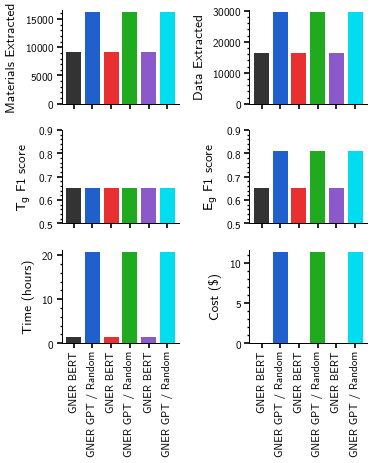

In [59]:
plt.rcParams['font.family'] = 'cursive'
colors = ["#333", "#2060cc", "#e93030", "#20aa20", "#8a5aca", "#00ddee", "m", "#e4a635"][:metrics.shape[0]]

fig, axes = plt.subplots(3, 2, figsize=(3.25, 4), sharex=True)
axes = axes.flatten()

barprops = dict(color=colors, align='center', width=0.8)

ax = axes[0]
metrics['materials'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='Materials Extracted')

ax = axes[1]
metrics['properties'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='Data Extracted')

ax = axes[2]
metrics['Tg'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='$T_g$ F1 score', ylim=(0.5, 0.9))

ax = axes[3]
metrics['Eg'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='$E_g$ F1 score', ylim=(0.5, 0.9))

ax = axes[4]
metrics['hours'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='Time (hours)')

ax = axes[5]
metrics['cost'].plot.bar(ax=ax, **barprops)
ax.set(ylabel='Cost (\$)')


for ax in axes.flatten():
    ax.set(xlabel='')
    ax.tick_params(axis='x', which='minor', bottom=False)

plt.tight_layout()
plt.savefig("notebooks/Selec1k-Bars.eps")
plt.show()